As a huge t-wolves fan, I've been curious all year by what we can infer from Karl-Anthony Towns' great rookie season. To answer this question, I've create a simple linear regression model that uses rookie year performance to predict career performance. 

Many have attempted to predict NBA players' success via regression style approaches. Notable models I know of include [Layne Vashro's model](http://laynevashro.com/basketball/predsFAQ.html) which uses combine and college performance to predict career performance. Layne Vashro's model is a quasi-poisson GLM. I tried a similar approach, but had the most success when using ws/48 and OLS. I will discuss this a little more at the end of the post.  

In [30]:
#import some libraries and tell ipython we want inline figures rather than interactive figures. 
import matplotlib.pyplot as plt, pandas as pd, numpy as np, matplotlib as mpl

from __future__ import print_function

%matplotlib inline
pd.options.display.mpl_style = 'default' #load matplotlib for plotting
plt.style.use('ggplot') #im addicted to ggplot. so pretty.
mpl.rcParams['font.family'] = ['Bitstream Vera Sans']


I collected all the data for this project from basketball-reference.com. I posted the functions for collecting the data on my [github](https://github.com/dvatterott/nba_project). The data is also posted there. Beware, the data collection scripts take awhile to run.  

This data includes per 36 stats and advanced statistics such as usage percentage. I simply took all the per 36 and advanced statistics from a player's page on basketball-reference.com.

In [31]:
df = pd.read_pickle('nba_bballref_career_stats_2016_Mar_15.pkl') #here's the career data. 
rookie_df = pd.read_pickle('nba_bballref_rookie_stats_2016_Mar_15.pkl') #here's the rookie year data

The variable I am trying to predict is average [WS/48](http://www.basketball-reference.com/about/ws.html) over a player's career. There's no perfect box-score statistic when it comes to quantifying a player's peformance, but ws/48 seems relatively solid. 

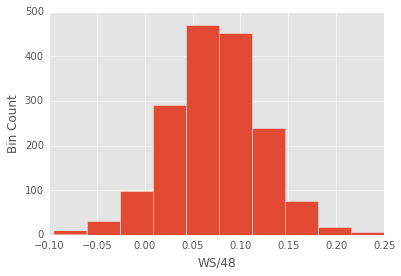

In [32]:
Games = df['G']>50 #only using players who played in more than 50 games.
Year = df['Year']>1980 #only using players after 1980 when they started keeping many important records such as games started

Y = df[Games & Year]['WS/48'] #predicted variable

plt.hist(Y);
plt.ylabel('Bin Count')
plt.xlabel('WS/48');

The predicted variable looks pretty gaussian, so I can use ordinary least squares. This will be nice because while ols is not flexible, it's highly interpretable. At the end of the post I'll mention some more complex models that I will try. 

In [33]:
rook_games = rookie_df['Career Games']>50
rook_year = rookie_df['Year']>1980

#remove rookies from before 1980 and who have played less than 50 games. I also remove some features that seem irrelevant or unfair
rookie_df_games = rookie_df[rook_games & rook_year] #only players with more than 50 games. 
rookie_df_drop = rookie_df_games.drop(['Year','Career Games','Name'],1)

Above, I remove some predictors from the rookie data. Lets run the regression!

In [34]:
import statsmodels.api as sm 

X_rookie = rookie_df_drop.as_matrix() #take data out of dataframe
X_rookie = sm.add_constant(X_rookie)  # Adds a constant term to the predictor

estAll = sm.OLS(Y,X_rookie) #create ordinary least squares model
estAll = estAll.fit() #fit the model
print(estAll.summary())

                            OLS Regression Results                            
Dep. Variable:                  WS/48   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     31.72
Date:                Sun, 20 Mar 2016   Prob (F-statistic):          2.56e-194
Time:                        15:29:43   Log-Likelihood:                 3303.9
No. Observations:                1690   AIC:                            -6512.
Df Residuals:                    1642   BIC:                            -6251.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2509      0.078      3.223      0.0

There's a lot to look at in the regression output (especially with this many features). For an explanation of all the different parts of the regression take a look at this [post](http://connor-johnson.com/2014/02/18/linear-regression-with-python/). Below is a quick plot of predicted ws/48 against actual ws/48.

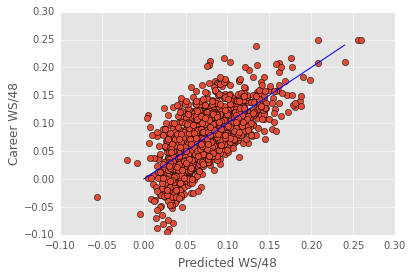

In [35]:
plt.plot(estAll.predict(X_rookie),Y,'o')
plt.plot(np.arange(0,0.25,0.01),np.arange(0,0.25,0.01),'b-')
plt.ylabel('Career WS/48')
plt.xlabel('Predicted WS/48');

The blue line above is NOT the best-fit line. It's the identity line. I plot it to help visualize where the model fails. The model seems to primarily fail in the extremes - it tends to overestimate the worst players. 

All in all, This model does a remarkably good job given its simplicity (linear regression), but it also leaves a lot of variance unexplained. 

One reason this model might miss some variance is there's more than one way to be a productive basketball player. For instance, Dwight Howard and Steph Curry find very different ways to contribute. One linear regression model is unlikely to succesfully predict both players. 

In a [previous post](http://www.danvatterott.com/blog/2016/02/21/grouping-nba-players/), I grouped players according to their on-court performance. These player groupings might help predict career performance. 

Below, I will use the same player grouping I developed in my previous post, and examine how these groupings impact my ability to predict career performance. 

In [57]:
from sklearn.preprocessing import StandardScaler

df = pd.read_pickle('nba_bballref_career_stats_2016_Mar_15.pkl')
df = df[df['G']>50]
df_drop = df.drop(['Year','Name','G','GS','MP','FG','FGA','FG%','3P','2P','FT','TRB','PTS','ORtg','DRtg','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'],1)
X = df_drop.as_matrix() #take data out of dataframe
ScaleModel = StandardScaler().fit(X)
X = ScaleModel.transform(X)

In [58]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

reduced_model = PCA(n_components=5, whiten=True).fit(X)

reduced_data = reduced_model.transform(X) #transform data into the 5 PCA components space
final_fit = KMeans(n_clusters=6).fit(reduced_data) #fit 6 clusters
df['kmeans_label'] = final_fit.labels_ #label each data point with its clusters

See my other post for more details about this clustering procedure. 

Let's see how WS/48 varies across the groups.

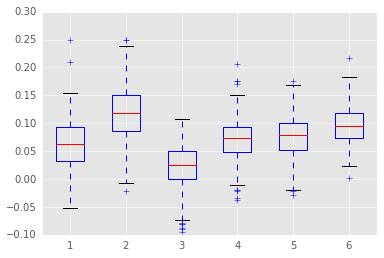

In [59]:
WS_48 = [df[df['kmeans_label']==x]['WS/48'] for x in np.unique(df['kmeans_label'])] #create a vector of ws/48. One for each cluster
plt.boxplot(WS_48);

Some groups perform better than others, but there's lots of overlap between the groups. Importantly, each group has a fair amount of variability. Each group spans at least 0.15 WS/48. This gives the regression enough room to successfully predict performance in each group. 

Now, lets get a bit of a refresher on what the groups are. Again, my previous post has a good description of these groups. 

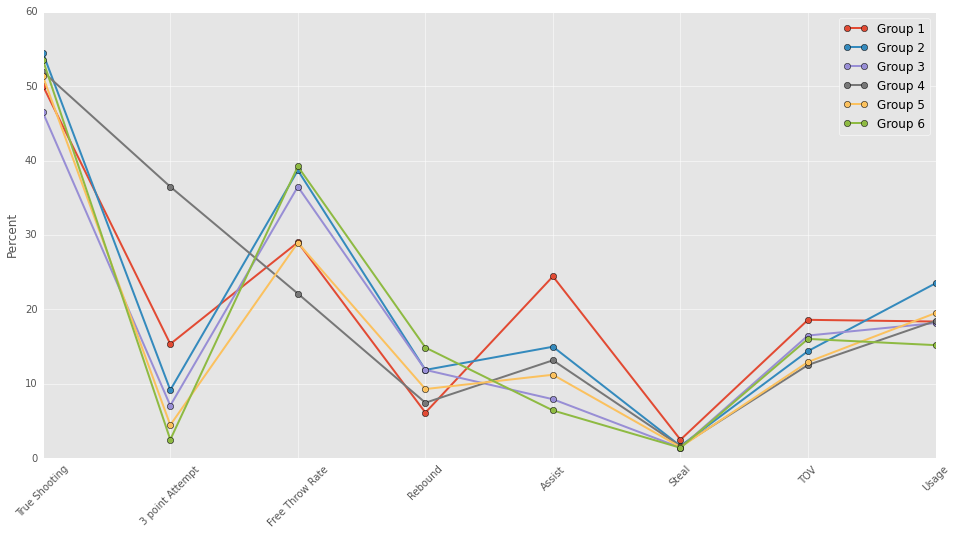

In [60]:
TS = [np.mean(df[df['kmeans_label']==x]['TS%'])*100 for x in np.unique(df['kmeans_label'])] #create vectors of each stat for each cluster
ThreeAr = [np.mean(df[df['kmeans_label']==x]['3PAr'])*100 for x in np.unique(df['kmeans_label'])]
FTr = [np.mean(df[df['kmeans_label']==x]['FTr'])*100 for x in np.unique(df['kmeans_label'])]
RBD = [np.mean(df[df['kmeans_label']==x]['TRB%']) for x in np.unique(df['kmeans_label'])]
AST = [np.mean(df[df['kmeans_label']==x]['AST%']) for x in np.unique(df['kmeans_label'])]
STL = [np.mean(df[df['kmeans_label']==x]['STL%']) for x in np.unique(df['kmeans_label'])]
TOV = [np.mean(df[df['kmeans_label']==x]['TOV%']) for x in np.unique(df['kmeans_label'])]
USG = [np.mean(df[df['kmeans_label']==x]['USG%']) for x in np.unique(df['kmeans_label'])]

Data = np.array([TS,ThreeAr,FTr,RBD,AST,STL,TOV,USG])
ind = np.arange(1,9)

plt.figure(figsize=(16,8))
plt.plot(ind,Data,'o-',linewidth=2)
plt.xticks(ind,('True Shooting', '3 point Attempt', 'Free Throw Rate', 'Rebound', 'Assist','Steal','TOV','Usage'),rotation=45)
plt.legend(('Group 1','Group 2','Group 3','Group 4','Group 5','Group 6'))
plt.ylabel('Percent');

I've plotted the groups across a number of useful categories. For information about these categories see [basketball reference's glossary](http://www.basketball-reference.com/about/glossary.html).

Here's a quick rehash of the groupings. See my [previous post](http://www.danvatterott.com/blog/2016/02/21/grouping-nba-players/) for more detail.

<ul>
<li><b>Group 1:</b> These are the distributors who shoot a fair number of threes, don't rebound at all, dish out assists, gather steals, and ...turn the ball over.</li> 
<li><b>Group 2:</b> These are the scorers who get to the free throw line, dish out assists, and carry a high usage.</li> 
<li><b>Group 3:</b> These are the bench players who don't score...or do much in general.</li>
<li><b>Group 4:</b> These are the 3 point shooters who shoot tons of 3 pointers, almost no free throws, and don't rebound well.</li>
<li><b>Group 5:</b> These are the mid-range shooters who shoot well, but don't shoot threes or draw free throws</li>
<li><b>Group 6:</b> These are the defensive big men who shoot no threes, rebound lots, and carry a low usage.</li>
</ul>

On to the regression.

In [61]:
rookie_df = pd.read_pickle('nba_bballref_rookie_stats_2016_Mar_15.pkl')
rookie_df = rookie_df.drop(['Year','Career Games','Name'],1)

X = rookie_df.as_matrix() #take data out of dataframe
ScaleRookie = StandardScaler().fit(X) #scale data
X = ScaleRookie.transform(X) #transform data to scale

reduced_model_rookie = PCA(n_components=10).fit(X) #create pca model of first 10 components. 

You might have noticed the giant condition number in the regression above. This indicates significant [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) of the features, which isn't surprising since I have many features that reflect the same abilities. 

The multicollinearity doesn't prevent the regression model from making accurate predictions, but does it make the beta weight estimates irratic. With irratic beta weights, it's hard to tell whether the different clusters use different models when predicting career ws/48. 

In the following regression, I put the predicting features through a PCA and keep only the first 10 PCA components. Using only the first 10 PCA components keeps the component score below 20, indicating that multicollinearity is not a problem. I then examine whether the different groups exhibit a different patterns of beta weights (whether different models predict success of the different groups). 

In [62]:
cluster_labels = df[df['Year']>1980]['kmeans_label'] #limit labels to players after 1980
rookie_df_drop['kmeans_label'] = cluster_labels #label each data point with its clusters

estHold = [[],[],[],[],[],[]]

for i,group in enumerate(np.unique(final_fit.labels_)):
           
    Grouper = df['kmeans_label']==group #do regression one group at a time
    Yearer = df['Year']>1980
    
    Group1 = df[Grouper & Yearer]
    Y = Group1['WS/48'] #get predicted data
    
    Group1_rookie = rookie_df_drop[rookie_df_drop['kmeans_label']==group] #get predictor data of group
    Group1_rookie = Group1_rookie.drop(['kmeans_label'],1)

    X = Group1_rookie.as_matrix() #take data out of dataframe
    X = ScaleRookie.transform(X) #scale data
    
    X = reduced_model_rookie.transform(X) #transform data into the 10 PCA components space
    
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    est = sm.OLS(Y,X) #create regression model
    est = est.fit()
    #print(est.summary())
    estHold[i] = est 
    

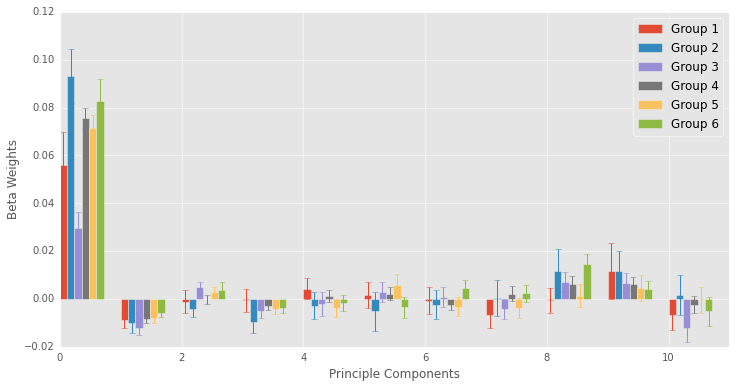

In [63]:
plt.figure(figsize=(12,6)) #plot the beta weights
width=0.12
for i,est in enumerate(estHold):
    plt.bar(np.arange(11)+width*i,est.params,color=plt.rcParams['axes.color_cycle'][i],width=width,yerr=(est.conf_int()[1]-est.conf_int()[0])/2)
    
plt.xlim(right=11)
plt.xlabel('Principle Components')
plt.legend(('Group 1','Group 2','Group 3','Group 4','Group 5','Group 6'))
plt.ylabel('Beta Weights');

Above I plot the beta weights for each principle component across the groupings. This plot is a lot to look at, but I wanted to depict how the beta values changed across the groups. They are not drastically different, but they're also not identical. Error bars depict 95% confidence intervals. 

Below I fit a regression to each group, but with all the features. Again, multicollinearity will be a problem, but this will not decrease the regression's accuracy, which is all I really care about.

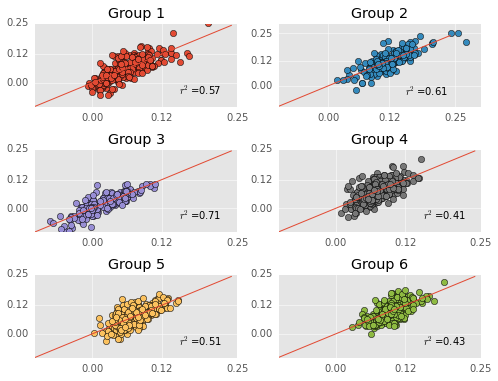

In [64]:
X = rookie_df.as_matrix() #take data out of dataframe

cluster_labels = df[df['Year']>1980]['kmeans_label']
rookie_df_drop['kmeans_label'] = cluster_labels #label each data point with its clusters

plt.figure(figsize=(8,6));

estHold = [[],[],[],[],[],[]]

for i,group in enumerate(np.unique(final_fit.labels_)):
           
    Grouper = df['kmeans_label']==group #do one regression at a time
    Yearer = df['Year']>1980
    
    Group1 = df[Grouper & Yearer]
    Y = Group1['WS/48'] #get predictor data
    
    Group1_rookie = rookie_df_drop[rookie_df_drop['kmeans_label']==group]
    Group1_rookie = Group1_rookie.drop(['kmeans_label'],1) #get predicted data

    X = Group1_rookie.as_matrix() #take data out of dataframe    
    
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    est = sm.OLS(Y,X) #fit with linear regression model
    est = est.fit()
    estHold[i] = est
    #print est.summary()
    
    plt.subplot(3,2,i+1) #plot each regression's prediction against actual data
    plt.plot(est.predict(X),Y,'o',color=plt.rcParams['axes.color_cycle'][i])
    plt.plot(np.arange(-0.1,0.25,0.01),np.arange(-0.1,0.25,0.01),'-')
    plt.title('Group %d'%(i+1))
    plt.text(0.15,-0.05,'$r^2$=%.2f'%est.rsquared)
    plt.xticks([0.0,0.12,0.25])
    plt.yticks([0.0,0.12,0.25]); 

The plots above depict each regression's predictions against actual ws/48. I provide each model's r^2 in the plot too. 

Some regressions are better than others. For instance, the regression model does a pretty awesome job predicting the bench warmers...I wonder if this is because they have shorter careers... The regression model does not do a good job predicting the 3-point shooters.

Now onto the fun stuff though. 

Below, create a function for predicting a players career WS/48. First, I write a function that finds what cluster a player would belong to, and what the regression model predicts for this players career (with 95% confidence intervals). 

In [65]:
def player_prediction__regressionModel(PlayerName):
    from statsmodels.sandbox.regression.predstd import wls_prediction_std
    
    clust_df = pd.read_pickle('nba_bballref_career_stats_2016_Mar_05.pkl')
    clust_df = clust_df[clust_df['Name']==PlayerName]
    clust_df = clust_df.drop(['Name','G','GS','MP','FG','FGA','FG%','3P','2P','FT','TRB','PTS','ORtg','DRtg','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP'],1)
    new_vect = ScaleModel.transform(clust_df.as_matrix()[0])
    reduced_data = reduced_model.transform(new_vect) 
    Group = final_fit.predict(reduced_data)
    clust_df['kmeans_label'] = Group[0]

    Predrookie_df = pd.read_pickle('nba_bballref_rookie_stats_2016_Mar_15.pkl')
    Predrookie_df = Predrookie_df[Predrookie_df['Name']==PlayerName]
    Predrookie_df = Predrookie_df.drop(['Year','Career Games','Name'],1)
    predX = Predrookie_df.as_matrix() #take data out of dataframe
    predX = sm.add_constant(predX,has_constant='add')  # Adds a constant term to the predictor
    prstd_ols, iv_l_ols, iv_u_ols = wls_prediction_std(estHold[Group[0]],predX,alpha=0.05)
    return {'Name':PlayerName,'Group':Group[0]+1,'Prediction':estHold[Group[0]].predict(predX),'Upper_CI':iv_u_ols,'Lower_CI':iv_l_ols}


Here I create a function that creates a list of all the first round draft picks from a given year. 

In [66]:
def gather_draftData(Year):
    
    import urllib2
    from bs4 import BeautifulSoup
    import pandas as pd
    import numpy as np
    
    draft_len = 30
    
    def convert_float(val):
        try:
            return float(val)
        except ValueError:
            return np.nan
    
    url = 'http://www.basketball-reference.com/draft/NBA_'+str(Year)+'.html'
    html = urllib2.urlopen(url)
    soup = BeautifulSoup(html,"lxml")
    
    draft_num = [soup.findAll('tbody')[0].findAll('tr')[i].findAll('td')[0].text for i in range(draft_len)]
    draft_nam = [soup.findAll('tbody')[0].findAll('tr')[i].findAll('td')[3].text for i in range(draft_len)]
        
    draft_df = pd.DataFrame([draft_num,draft_nam]).T
    draft_df.columns = ['Number','Name']
    df.index = range(np.size(df,0))
    return draft_df

Below I create predictions for each first-round draft pick from 2015. The spurs' first round pick, Nikola Milutinov, has yet to play so I do not create a prediction for him. 

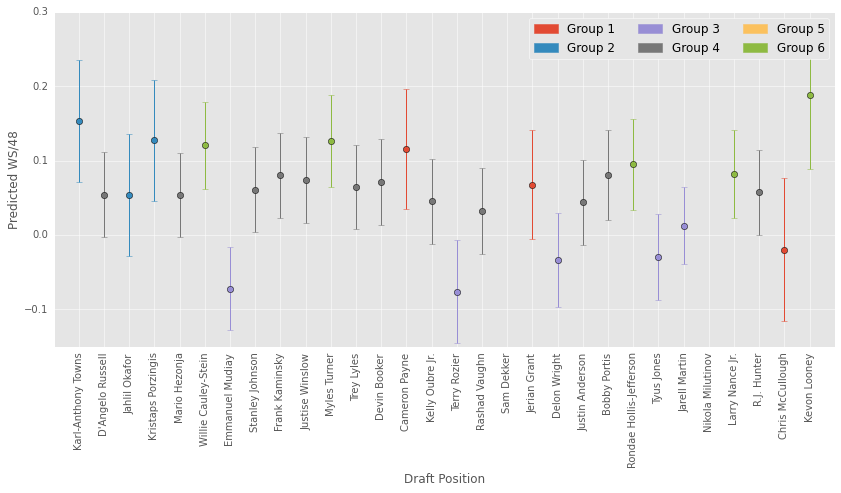

In [67]:
import matplotlib.patches as mpatches

draft_df = gather_draftData(2015)

draft_df['Name'][14] =  'Kelly Oubre Jr.' #annoying name inconsistencies 

plt.subplots(figsize=(14,6));
plt.xticks(range(1,31),draft_df['Name'],rotation=90)

draft_df = draft_df.drop(17, 0) #Sam Dekker has received little playing time making his prediction highly irratic
draft_df = draft_df.drop(25, 0) #spurs' 1st round pick has not played yet

for name in draft_df['Name']:
        
    draft_num = draft_df[draft_df['Name']==name]['Number']
        
    predict_dict = player_prediction__regressionModel(name)
    yerr = (predict_dict['Upper_CI']-predict_dict['Lower_CI'])/2
        
    plt.errorbar(draft_num,predict_dict['Prediction'],fmt='o',label=name,
                color=plt.rcParams['axes.color_cycle'][predict_dict['Group']-1],yerr=yerr);

plt.xlim(left=0,right=31)
patch = [mpatches.Patch(color=plt.rcParams['axes.color_cycle'][i], label='Group %d'%(i+1)) for i in range(6)]
plt.legend(handles=patch,ncol=3)
plt.ylabel('Predicted WS/48')
plt.xlabel('Draft Position');

The plot above is ordered by draft pick. The error bars depict 95% confidence interbals...which are a little wider than I would like. It's interesting to look at what clusters these players fit into. Lots of 3-pt shooters! It could be that rookies play a limited role in the offense - just shooting 3s. 

As a t-wolves fan, I am relatively happy about the high prediction for Karl-Anthony Towns. His predicted ws/48 is between Marc Gasol and Elton Brand. Again, the CIs are quite wide, so the model says there's a 95% chance he is somewhere between Lebron James ever and a player that averages less than 0.1 ws/48. 

Karl-Anthony Towns would have the highest predicted ws/48 if it were not for Kevin Looney who the model loves. Kevin Looney has not seen much playing time though, which likely makes his prediction more erratic. Keep in mind I did not use draft position as a predictor in the model.

Sam Dekker has a pretty huge error bar, likely because of his limited playing time this year. 

While I fed a ton of features into this model, it's still just a linear regression. The simplicity of the model might prevent me from making more accurate predictions.

I've already started playing with some more complex models. If those work out well, I will post them here. I ended up sticking with a plain linear regression because my vast number of features is a little unwieldy in a more complex models. If you're interested (and the models produce better results) check back in the future. 

For now, these models explain between 40 and 70% of the variance in career ws/48 from only a player's rookie year. Even predicting 30% of variance is pretty remarkable, so I don't want to trash on this part of the model. Explaining 65% of the variance is pretty awesome. The model gives us a pretty accurate idea of how these "bench players" will perform. For instance, the future does not look bright for players like Emmanuel Mudiay and Tyus Jones. Not to say these players are doomed. The model assumes that players will retain their grouping for the entire career. Emmanuel Mudiay and Tyus Jones might start performing more like distributors as their career progresses. This could result in a better career. 

One nice part about this model is it tells us where the predictions are less confident. For instance, it is nice to know that we're relatively confident when predicting bench players, but not when we're predicting 3-point shooters. 

For those curious, I output each groups regression summary below. 

In [20]:
[print(i.summary()) for i in estHold];

                            OLS Regression Results                            
Dep. Variable:                  WS/48   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     8.939
Date:                Sun, 20 Mar 2016   Prob (F-statistic):           2.33e-24
Time:                        10:40:28   Log-Likelihood:                 493.16
No. Observations:                 212   AIC:                            -912.3
Df Residuals:                     175   BIC:                            -788.1
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.1072      0.064     -1.682      0.0